# Jupyter Notebook Assignment: Heartbeat Classification with RNN, LSTM, and GRU

## Title: Heartbeat Classification using Sequence Models

### Objective:
In this assignment, you will build, train, and evaluate three different sequence models (RNN, LSTM, GRU) to classify heartbeats based on ECG data. You will compare their performance using metrics such as AUC, F1-score, and accuracy. Additionally, you will explore the data and visualize the results for better understanding.


1. **Dataset Overview:**
   - The dataset contains heartbeat signals derived from two well-known datasets: the MIT-BIH Arrhythmia Dataset and PhysioNet's MIT-BIH Arrhythmia Database.
   - Each row in the dataset is a time series corresponding to one heartbeat, and the signals represent electrocardiogram (ECG) waveforms.
   - The dataset is preprocessed and segmented, with each segment corresponding to a heartbeat. The last column represents the label (5 classes):
     - **'N': 0** - Normal heartbeat
     - **'S': 1** - Supraventricular premature beat
     - **'V': 2** - Premature ventricular contraction
     - **'F': 3** - Fusion of ventricular and normal beat
     - **'Q': 4** - Unclassifiable beat
   - Number of Samples: **109,446**
   - Sampling Frequency: **125 Hz**
   - Training data: `mitbih_train.csv`
   - Testing data: `mitbih_test.csv`
   - Data Source: PhysioNet's MIT-BIH Arrhythmia Dataset

   **Background:**
   - The MIT-BIH Arrhythmia Database includes 48 half-hour excerpts of two-channel ambulatory ECG recordings from 47 subjects, recorded between 1975 and 1979. These recordings were selected to include less common but clinically significant arrhythmias.
   - Each recording was digitized at 360 samples per second per channel, annotated independently by two or more cardiologists.

2. **Assignment Tasks:**

    * When working on graded functions, please remember to only modify the code that is between the
    ```Python
    #### START CODE HERE
    ```
    and
    ```Python
    #### END CODE HERE
    ```

   #### Task 1: Data Exploration
   - Load the data and explore its structure.
   - Plot a few ECG signals for visualization.
   - Check the distribution of classes and identify any imbalance.

   #### Task 2: Model Implementation
   - Implement three sequence models: RNN, LSTM, and GRU.
   - Define the architecture for each model.
   - Train each model on the training dataset.

   #### Task 3: Performance Evaluation
   - Evaluate the performance of each model using:
     - AUC (Area Under the Curve)
     - F1-score
     - Accuracy
   - Generate a confusion matrix for each model.
   - Plot training and testing loss, AUC, F1-score, and accuracy for each epoch.

   #### Task 4: Results Comparison
   - Compare the performance of the three models using tables and plots.
   - Discuss which model performed the best and why.

   #### Task 5: Visualization and Insights
   - Visualize key insights such as class-wise performance, confusion matrix heatmaps, and metric trends over epochs.

3. **Deliverables:**
   - Submit a completed Jupyter Notebook with:
     - Code for all tasks.
     - Plots and visualizations.
     - A short discussion on the results.

4. **Grading Criteria:**
   - Correctness and completeness of the implementation.
   - Quality of visualizations.
   - Depth of analysis in the discussion.

5. **Tips:**
   - Use GPU for faster training.
   - Document your code with comments for better readability.
   - Use libraries like `matplotlib` and `seaborn` for visualizations.

---

## Assignments:

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the data
def load_data(train_path, test_path):
    
    #### START CODE HERE
    # Load train and test datasets using pandas
    # Note: Each row represents a time series with 187 time steps, each having one feature value, and the last column contains the label indicating 1 of 5 classes

    train_df = pd.read_csv(train_path, header=None)
    test_df = pd.read_csv(test_path, header=None)

    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values

    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values
    
    #### END CODE HERE
    
    return X_train, y_train, X_test, y_test

In [5]:
# Dataset class
class HeartbeatDataset(Dataset):
    def __init__(self, X, y):
        
        ####START CODE HERE
        # Instruction: Replace this with a PyTorch Dataset class implementation.
        self.X = torch.tensor(X, dtype=torch.float).unsqueeze(-1) # (batch_size, sequence_length x input_size) --> (batch_size, sequence_length, input_size) 
        self.y = torch.tensor(y, dtype=torch.long)
        #### END CODE HERE

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# Data exploration
def explore_data(X_train, y_train):
    # Check data structure
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)

    # Plot a few ECG signals
    plt.figure(figsize=(12, 6))
    for i in range(5):
        ####START CODE HERE
        # Instruction: Replace this with your own implementation to explore and visualize the data.
        plt.plot(X_train[i], label=f"Sample {i}, Class {y_train[i]}")
        #### END CODE HERE
    plt.title("Sample ECG Signals")
    plt.xlabel("Time Step")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.savefig("sample_ecg_signals.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Check class distribution
    class_counts = pd.Series(y_train).value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
# RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        ####START CODE HERE
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        #### END CODE HERE

    def forward(self, x): 
        ####START CODE HERE # [batch, seqlen, input]
        out, hn = self.rnn(x) # [batch, seqlen, hidden], [num_layers, batch, hidden]
        out = out[:, -1, :] # [batch, hidden]
        out = self.dropout(out)
        out = self.fc(out) # [batch, class]
        #### END CODE HERE
        return out

In [8]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        ####START CODE HERE
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        #### END CODE HERE

    def forward(self, x):
        ####START CODE HERE # [batch, seqlen, input]
        out, (hn, cn) = self.lstm(x) # [batch, seqlen, hidden], ([num_layers, batch, hidden], [num_layers, batch, hidden])
        out = out[:, -1, :] # [batch, hidden]
        out = self.dropout(out)
        out = self.fc(out) # [batch, class]
        #### END CODE HERE
        return out



In [9]:
# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        ####START CODE HERE
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        #### END CODE HERE

    def forward(self, x):
        ####START CODE HERE
        out, hn = self.gru(x) # [batch, seqlen, hidden], [num_layers, batch, hidden]
        out = out[:, -1, :] # [batch, hidden]
        out = self.dropout(out)
        out = self.fc(out) # [batch, class]
        #### END CODE HERE
        return out

In [10]:
# Training and evaluation functions
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    for X, y in tqdm(train_loader):
        ####START CODE HERE
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs= model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())
        #### END CODE HERE
    
    auc = roc_auc_score(pd.get_dummies(all_targets), pd.get_dummies(all_preds), multi_class='ovr')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(train_loader), auc, f1, acc


def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y in tqdm(data_loader):
            ####START CODE HERE
            X, y = X.to(device), y.to(device)

            outputs= model(X)
            loss = criterion(outputs, y)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            
            #### END CODE HERE
    
    auc = roc_auc_score(pd.get_dummies(all_targets), pd.get_dummies(all_preds), multi_class='ovr')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(data_loader), auc, f1, acc

def plot_metrics(train_metrics, test_metrics, epochs, model_name):
    plt.figure(figsize=(12, 6))
    for metric_name in train_metrics.keys():
        plt.plot(range(epochs), train_metrics[metric_name], label=f"Train {metric_name}")
        plt.plot(range(epochs), test_metrics[metric_name], label=f"Test {metric_name}", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(f"{model_name}: Metrics")
    plt.legend()
    plt.savefig(f"{model_name}_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()

### Begin analysis

In [11]:
train_path = "mitbih_train.csv"
test_path = "mitbih_test.csv"

# Load data
X_train, y_train, X_test, y_test = load_data(train_path, test_path)

Shape of X_train: (87554, 187)
Shape of y_train: (87554,)


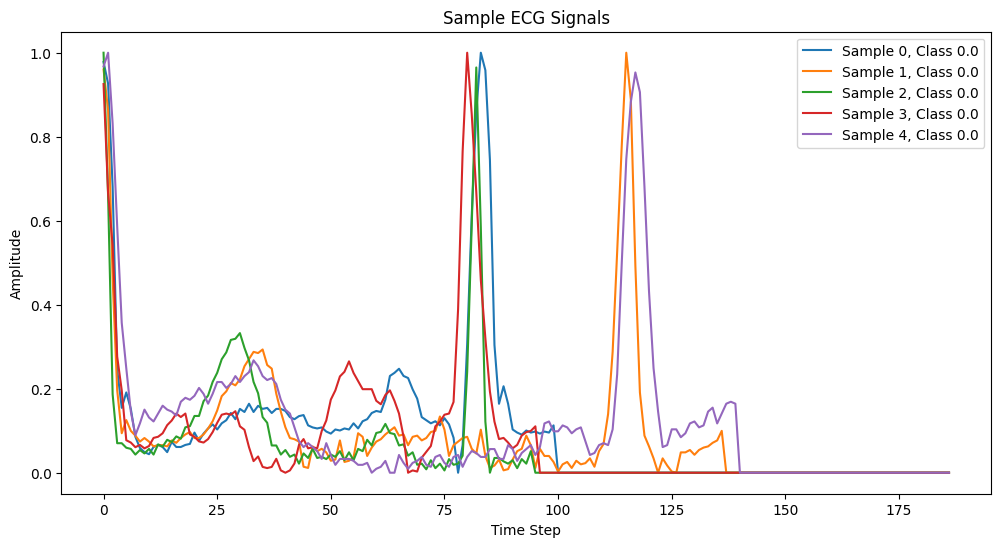

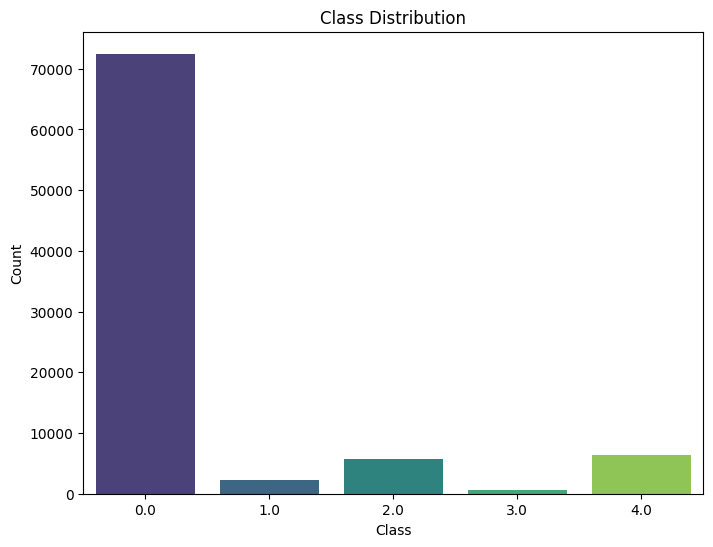

In [12]:
# Explore data
explore_data(X_train, y_train)

cuda
Training RNN...


100%|██████████| 343/343 [00:00<00:00, 1210.13it/s]


Epoch 1/50: Train Loss: 0.6634, Test Loss: 0.6407, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1219.26it/s]


Epoch 2/50: Train Loss: 0.6522, Test Loss: 0.6654, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1194.17it/s]


Epoch 3/50: Train Loss: 0.6542, Test Loss: 0.6429, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1221.26it/s]


Epoch 4/50: Train Loss: 0.6409, Test Loss: 0.6412, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1229.90it/s]


Epoch 5/50: Train Loss: 0.6422, Test Loss: 0.6447, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1063.76it/s]


Epoch 6/50: Train Loss: 0.6403, Test Loss: 0.6425, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1162.27it/s]


Epoch 7/50: Train Loss: 0.6408, Test Loss: 0.6414, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1215.86it/s]


Epoch 8/50: Train Loss: 0.6400, Test Loss: 0.6427, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1294.66it/s]


Epoch 9/50: Train Loss: 0.6423, Test Loss: 0.6440, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1168.14it/s]


Epoch 10/50: Train Loss: 0.6404, Test Loss: 0.6454, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1155.54it/s]


Epoch 11/50: Train Loss: 0.6401, Test Loss: 0.6427, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1182.37it/s]


Epoch 12/50: Train Loss: 0.6413, Test Loss: 0.6463, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1246.59it/s]


Epoch 13/50: Train Loss: 0.6400, Test Loss: 0.6410, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1264.39it/s]


Epoch 14/50: Train Loss: 0.6403, Test Loss: 0.6421, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1146.28it/s]


Epoch 15/50: Train Loss: 0.6404, Test Loss: 0.6407, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1247.52it/s]


Epoch 16/50: Train Loss: 0.6393, Test Loss: 0.6463, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1267.39it/s]


Epoch 17/50: Train Loss: 0.6490, Test Loss: 0.6675, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1276.71it/s]


Epoch 18/50: Train Loss: 0.6628, Test Loss: 0.6679, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1229.95it/s]


Epoch 19/50: Train Loss: 0.6632, Test Loss: 0.6692, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1266.43it/s]


Epoch 20/50: Train Loss: 0.6627, Test Loss: 0.6665, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1254.31it/s]


Epoch 21/50: Train Loss: 0.6618, Test Loss: 0.6715, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1250.05it/s]


Epoch 22/50: Train Loss: 0.6628, Test Loss: 0.6751, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1255.87it/s]


Epoch 23/50: Train Loss: 0.6636, Test Loss: 0.6798, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1277.32it/s]


Epoch 24/50: Train Loss: 0.6626, Test Loss: 0.6725, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1261.63it/s]


Epoch 25/50: Train Loss: 0.6630, Test Loss: 0.6637, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1005.21it/s]


Epoch 26/50: Train Loss: 0.6628, Test Loss: 0.6699, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1256.15it/s]


Epoch 27/50: Train Loss: 0.6616, Test Loss: 0.6689, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1207.69it/s]


Epoch 28/50: Train Loss: 0.6620, Test Loss: 0.6643, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1265.84it/s]


Epoch 29/50: Train Loss: 0.6621, Test Loss: 0.6668, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1233.51it/s]


Epoch 30/50: Train Loss: 0.6631, Test Loss: 0.6702, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1257.61it/s]


Epoch 31/50: Train Loss: 0.6628, Test Loss: 0.6654, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1237.67it/s]


Epoch 32/50: Train Loss: 0.6629, Test Loss: 0.6652, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1248.22it/s]


Epoch 33/50: Train Loss: 0.6629, Test Loss: 0.6672, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1278.90it/s]


Epoch 34/50: Train Loss: 0.6620, Test Loss: 0.6679, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1213.82it/s]


Epoch 35/50: Train Loss: 0.6631, Test Loss: 0.6670, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1186.63it/s]


Epoch 36/50: Train Loss: 0.6619, Test Loss: 0.6644, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1239.10it/s]


Epoch 37/50: Train Loss: 0.6635, Test Loss: 0.6645, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1263.82it/s]


Epoch 38/50: Train Loss: 0.6621, Test Loss: 0.6666, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1256.01it/s]


Epoch 39/50: Train Loss: 0.6624, Test Loss: 0.6677, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1171.40it/s]


Epoch 40/50: Train Loss: 0.6628, Test Loss: 0.6631, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1269.13it/s]


Epoch 41/50: Train Loss: 0.6623, Test Loss: 0.6664, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1081.05it/s]


Epoch 42/50: Train Loss: 0.6627, Test Loss: 0.6660, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1048.01it/s]


Epoch 43/50: Train Loss: 0.6629, Test Loss: 0.6672, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1217.48it/s]


Epoch 44/50: Train Loss: 0.6615, Test Loss: 0.6690, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1322.89it/s]


Epoch 45/50: Train Loss: 0.6632, Test Loss: 0.6679, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1223.39it/s]


Epoch 46/50: Train Loss: 0.6631, Test Loss: 0.6676, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1140.57it/s]


Epoch 47/50: Train Loss: 0.6619, Test Loss: 0.6718, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1296.73it/s]


Epoch 48/50: Train Loss: 0.6635, Test Loss: 0.6706, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1297.43it/s]


Epoch 49/50: Train Loss: 0.6635, Test Loss: 0.6641, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 1059.96it/s]


Epoch 50/50: Train Loss: 0.6624, Test Loss: 0.6638, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


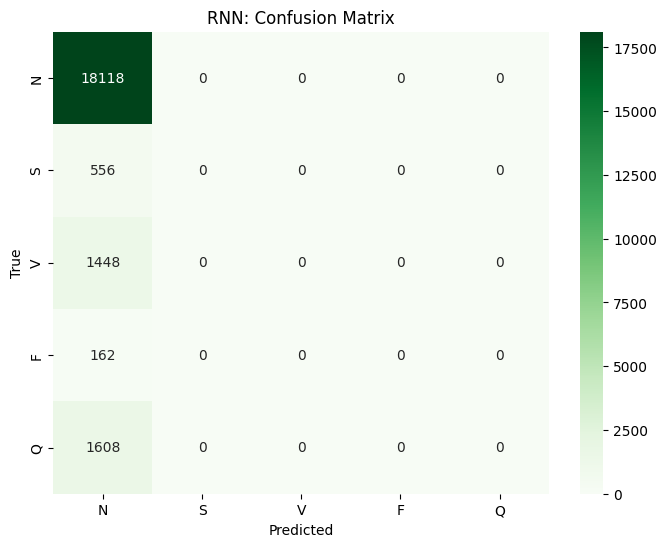

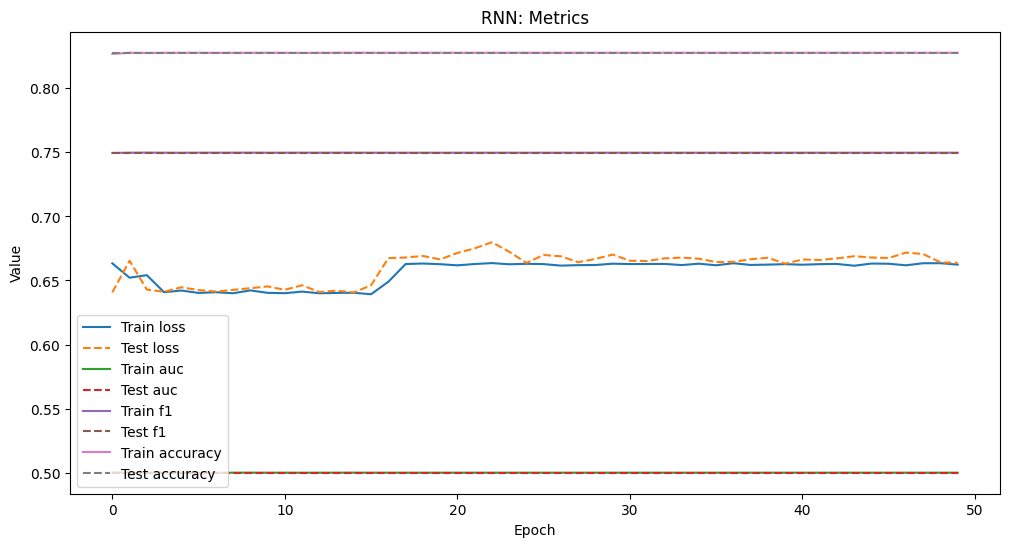

Training LSTM...


100%|██████████| 343/343 [00:00<00:00, 656.04it/s]


Epoch 1/50: Train Loss: 0.6591, Test Loss: 0.6494, Test AUC: 0.5207, Test F1: 0.7557, Test Acc: 0.8266


100%|██████████| 343/343 [00:00<00:00, 624.70it/s]


Epoch 2/50: Train Loss: 0.5555, Test Loss: 0.4182, Test AUC: 0.6016, Test F1: 0.8496, Test Acc: 0.8884


100%|██████████| 343/343 [00:00<00:00, 659.77it/s]


Epoch 3/50: Train Loss: 0.4496, Test Loss: 0.6582, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 602.43it/s]


Epoch 4/50: Train Loss: 0.6492, Test Loss: 0.6517, Test AUC: 0.5144, Test F1: 0.7534, Test Acc: 0.8266


100%|██████████| 343/343 [00:00<00:00, 653.83it/s]


Epoch 5/50: Train Loss: 0.6404, Test Loss: 0.6467, Test AUC: 0.5040, Test F1: 0.7504, Test Acc: 0.8277


100%|██████████| 343/343 [00:00<00:00, 626.78it/s]


Epoch 6/50: Train Loss: 0.6377, Test Loss: 0.6529, Test AUC: 0.5278, Test F1: 0.7533, Test Acc: 0.8266


100%|██████████| 343/343 [00:00<00:00, 661.62it/s]


Epoch 7/50: Train Loss: 0.6073, Test Loss: 0.6407, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276


100%|██████████| 343/343 [00:00<00:00, 595.24it/s]


Epoch 8/50: Train Loss: 0.5295, Test Loss: 0.4170, Test AUC: 0.5842, Test F1: 0.8426, Test Acc: 0.8842


100%|██████████| 343/343 [00:00<00:00, 679.05it/s]


Epoch 9/50: Train Loss: 0.3897, Test Loss: 0.4292, Test AUC: 0.6169, Test F1: 0.8444, Test Acc: 0.8506


100%|██████████| 343/343 [00:00<00:00, 660.78it/s]


Epoch 10/50: Train Loss: 0.3263, Test Loss: 0.3363, Test AUC: 0.5973, Test F1: 0.8782, Test Acc: 0.9037


100%|██████████| 343/343 [00:00<00:00, 680.14it/s]


Epoch 11/50: Train Loss: 0.2912, Test Loss: 0.2653, Test AUC: 0.6461, Test F1: 0.9102, Test Acc: 0.9268


100%|██████████| 343/343 [00:00<00:00, 598.43it/s]


Epoch 12/50: Train Loss: 0.2743, Test Loss: 0.2298, Test AUC: 0.6717, Test F1: 0.9187, Test Acc: 0.9329


100%|██████████| 343/343 [00:00<00:00, 642.67it/s]


Epoch 13/50: Train Loss: 0.2636, Test Loss: 0.2379, Test AUC: 0.6708, Test F1: 0.9178, Test Acc: 0.9305


100%|██████████| 343/343 [00:00<00:00, 628.02it/s]


Epoch 14/50: Train Loss: 0.2253, Test Loss: 0.2348, Test AUC: 0.6924, Test F1: 0.9229, Test Acc: 0.9331


100%|██████████| 343/343 [00:00<00:00, 634.85it/s]


Epoch 15/50: Train Loss: 0.2431, Test Loss: 0.2144, Test AUC: 0.7778, Test F1: 0.9342, Test Acc: 0.9399


100%|██████████| 343/343 [00:00<00:00, 603.48it/s]


Epoch 16/50: Train Loss: 0.1907, Test Loss: 0.1991, Test AUC: 0.8413, Test F1: 0.9454, Test Acc: 0.9468


100%|██████████| 343/343 [00:00<00:00, 618.72it/s]


Epoch 17/50: Train Loss: 0.1755, Test Loss: 0.1646, Test AUC: 0.8562, Test F1: 0.9540, Test Acc: 0.9571


100%|██████████| 343/343 [00:00<00:00, 608.23it/s]


Epoch 18/50: Train Loss: 0.1532, Test Loss: 0.1767, Test AUC: 0.8541, Test F1: 0.9484, Test Acc: 0.9508


100%|██████████| 343/343 [00:00<00:00, 651.19it/s]


Epoch 19/50: Train Loss: 0.1674, Test Loss: 0.2467, Test AUC: 0.7362, Test F1: 0.9186, Test Acc: 0.9312


100%|██████████| 343/343 [00:00<00:00, 630.86it/s]


Epoch 20/50: Train Loss: 0.1790, Test Loss: 0.1650, Test AUC: 0.8127, Test F1: 0.9511, Test Acc: 0.9558


100%|██████████| 343/343 [00:00<00:00, 613.79it/s]


Epoch 21/50: Train Loss: 0.1470, Test Loss: 0.1552, Test AUC: 0.8419, Test F1: 0.9541, Test Acc: 0.9560


100%|██████████| 343/343 [00:00<00:00, 651.45it/s]


Epoch 22/50: Train Loss: 0.1383, Test Loss: 0.2703, Test AUC: 0.7255, Test F1: 0.9106, Test Acc: 0.9241


100%|██████████| 343/343 [00:00<00:00, 674.16it/s]


Epoch 23/50: Train Loss: 0.1581, Test Loss: 0.1354, Test AUC: 0.8603, Test F1: 0.9593, Test Acc: 0.9615


100%|██████████| 343/343 [00:00<00:00, 655.59it/s]


Epoch 24/50: Train Loss: 0.1356, Test Loss: 0.1272, Test AUC: 0.8726, Test F1: 0.9657, Test Acc: 0.9678


100%|██████████| 343/343 [00:00<00:00, 622.02it/s]


Epoch 25/50: Train Loss: 0.1162, Test Loss: 0.1123, Test AUC: 0.8860, Test F1: 0.9683, Test Acc: 0.9704


100%|██████████| 343/343 [00:00<00:00, 625.87it/s]


Epoch 26/50: Train Loss: 0.1145, Test Loss: 0.1238, Test AUC: 0.8866, Test F1: 0.9649, Test Acc: 0.9665


100%|██████████| 343/343 [00:00<00:00, 640.42it/s]


Epoch 27/50: Train Loss: 0.1041, Test Loss: 0.1198, Test AUC: 0.8936, Test F1: 0.9643, Test Acc: 0.9662


100%|██████████| 343/343 [00:00<00:00, 639.30it/s]


Epoch 28/50: Train Loss: 0.1076, Test Loss: 0.1027, Test AUC: 0.8901, Test F1: 0.9711, Test Acc: 0.9730


100%|██████████| 343/343 [00:00<00:00, 616.55it/s]


Epoch 29/50: Train Loss: 0.0946, Test Loss: 0.1044, Test AUC: 0.9029, Test F1: 0.9705, Test Acc: 0.9720


100%|██████████| 343/343 [00:00<00:00, 629.39it/s]


Epoch 30/50: Train Loss: 0.0958, Test Loss: 0.0987, Test AUC: 0.9096, Test F1: 0.9722, Test Acc: 0.9734


100%|██████████| 343/343 [00:00<00:00, 641.62it/s]


Epoch 31/50: Train Loss: 0.0906, Test Loss: 0.1158, Test AUC: 0.8991, Test F1: 0.9670, Test Acc: 0.9670


100%|██████████| 343/343 [00:00<00:00, 652.15it/s]


Epoch 32/50: Train Loss: 0.0916, Test Loss: 0.0992, Test AUC: 0.9087, Test F1: 0.9714, Test Acc: 0.9723


100%|██████████| 343/343 [00:00<00:00, 638.76it/s]


Epoch 33/50: Train Loss: 0.0818, Test Loss: 0.0893, Test AUC: 0.9064, Test F1: 0.9747, Test Acc: 0.9762


100%|██████████| 343/343 [00:00<00:00, 653.91it/s]


Epoch 34/50: Train Loss: 0.0776, Test Loss: 0.0936, Test AUC: 0.9047, Test F1: 0.9749, Test Acc: 0.9761


100%|██████████| 343/343 [00:00<00:00, 635.75it/s]


Epoch 35/50: Train Loss: 0.0761, Test Loss: 0.0830, Test AUC: 0.9063, Test F1: 0.9758, Test Acc: 0.9770


100%|██████████| 343/343 [00:00<00:00, 654.45it/s]


Epoch 36/50: Train Loss: 0.0728, Test Loss: 0.0853, Test AUC: 0.9087, Test F1: 0.9765, Test Acc: 0.9777


100%|██████████| 343/343 [00:00<00:00, 638.92it/s]


Epoch 37/50: Train Loss: 0.0699, Test Loss: 0.0869, Test AUC: 0.8998, Test F1: 0.9752, Test Acc: 0.9765


100%|██████████| 343/343 [00:00<00:00, 673.64it/s]


Epoch 38/50: Train Loss: 0.0711, Test Loss: 0.0809, Test AUC: 0.9159, Test F1: 0.9776, Test Acc: 0.9788


100%|██████████| 343/343 [00:00<00:00, 687.79it/s]


Epoch 39/50: Train Loss: 0.0639, Test Loss: 0.0783, Test AUC: 0.9160, Test F1: 0.9780, Test Acc: 0.9790


100%|██████████| 343/343 [00:00<00:00, 659.00it/s]


Epoch 40/50: Train Loss: 0.0645, Test Loss: 0.0792, Test AUC: 0.9119, Test F1: 0.9785, Test Acc: 0.9796


100%|██████████| 343/343 [00:00<00:00, 646.43it/s]


Epoch 41/50: Train Loss: 0.0628, Test Loss: 0.0800, Test AUC: 0.9188, Test F1: 0.9789, Test Acc: 0.9799


100%|██████████| 343/343 [00:00<00:00, 649.05it/s]


Epoch 42/50: Train Loss: 0.0614, Test Loss: 0.0744, Test AUC: 0.9214, Test F1: 0.9795, Test Acc: 0.9803


100%|██████████| 343/343 [00:00<00:00, 663.78it/s]


Epoch 43/50: Train Loss: 0.0606, Test Loss: 0.0706, Test AUC: 0.9197, Test F1: 0.9798, Test Acc: 0.9807


100%|██████████| 343/343 [00:00<00:00, 686.36it/s]


Epoch 44/50: Train Loss: 0.0578, Test Loss: 0.0833, Test AUC: 0.9239, Test F1: 0.9785, Test Acc: 0.9794


100%|██████████| 343/343 [00:00<00:00, 621.02it/s]


Epoch 45/50: Train Loss: 0.0594, Test Loss: 0.0841, Test AUC: 0.9131, Test F1: 0.9777, Test Acc: 0.9788


100%|██████████| 343/343 [00:00<00:00, 623.63it/s]


Epoch 46/50: Train Loss: 0.0557, Test Loss: 0.1125, Test AUC: 0.8874, Test F1: 0.9665, Test Acc: 0.9683


100%|██████████| 343/343 [00:00<00:00, 682.76it/s]


Epoch 47/50: Train Loss: 0.0570, Test Loss: 0.0788, Test AUC: 0.9250, Test F1: 0.9772, Test Acc: 0.9780


100%|██████████| 343/343 [00:00<00:00, 643.43it/s]


Epoch 48/50: Train Loss: 0.0549, Test Loss: 0.0698, Test AUC: 0.9228, Test F1: 0.9809, Test Acc: 0.9817


100%|██████████| 343/343 [00:00<00:00, 686.53it/s]


Epoch 49/50: Train Loss: 0.0508, Test Loss: 0.0746, Test AUC: 0.9237, Test F1: 0.9784, Test Acc: 0.9790


100%|██████████| 343/343 [00:00<00:00, 600.11it/s]


Epoch 50/50: Train Loss: 0.0497, Test Loss: 0.0705, Test AUC: 0.9273, Test F1: 0.9808, Test Acc: 0.9815


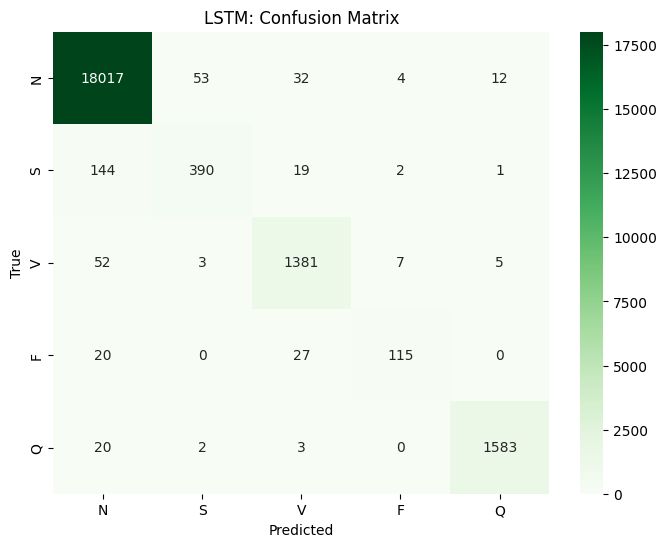

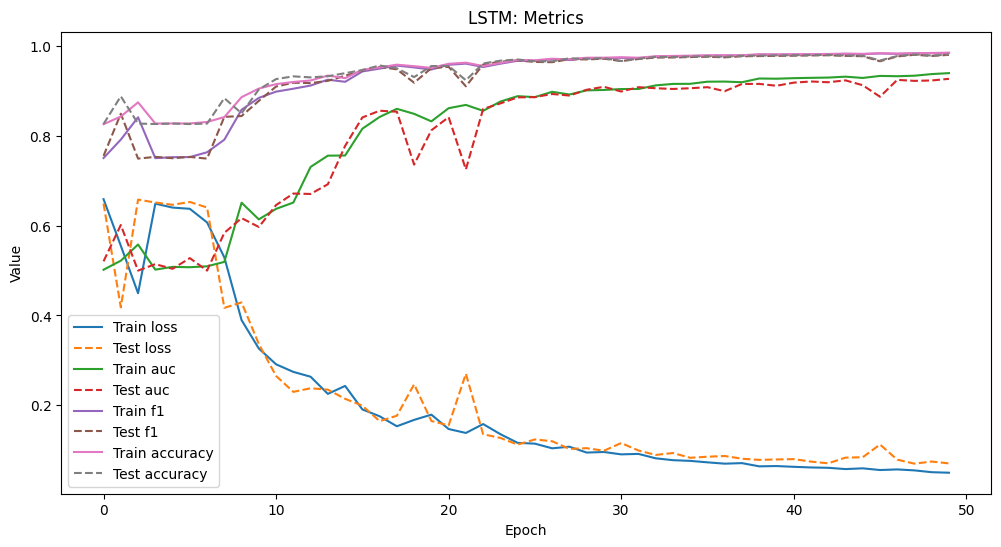

Training GRU...


100%|██████████| 343/343 [00:00<00:00, 1112.50it/s]


Epoch 1/50: Train Loss: 0.4032, Test Loss: 0.2050, Test AUC: 0.7866, Test F1: 0.9380, Test Acc: 0.9457


100%|██████████| 343/343 [00:00<00:00, 1125.40it/s]


Epoch 2/50: Train Loss: 0.1736, Test Loss: 0.1523, Test AUC: 0.8606, Test F1: 0.9599, Test Acc: 0.9616


100%|██████████| 343/343 [00:00<00:00, 1037.31it/s]


Epoch 3/50: Train Loss: 0.1355, Test Loss: 0.1366, Test AUC: 0.8656, Test F1: 0.9621, Test Acc: 0.9642


100%|██████████| 343/343 [00:00<00:00, 1063.36it/s]


Epoch 4/50: Train Loss: 0.1095, Test Loss: 0.1102, Test AUC: 0.8911, Test F1: 0.9701, Test Acc: 0.9715


100%|██████████| 343/343 [00:00<00:00, 1137.03it/s]


Epoch 5/50: Train Loss: 0.0991, Test Loss: 0.0904, Test AUC: 0.9113, Test F1: 0.9751, Test Acc: 0.9763


100%|██████████| 343/343 [00:00<00:00, 1083.72it/s]


Epoch 6/50: Train Loss: 0.0873, Test Loss: 0.0881, Test AUC: 0.9085, Test F1: 0.9751, Test Acc: 0.9760


100%|██████████| 343/343 [00:00<00:00, 1104.47it/s]


Epoch 7/50: Train Loss: 0.0803, Test Loss: 0.0875, Test AUC: 0.9126, Test F1: 0.9759, Test Acc: 0.9770


100%|██████████| 343/343 [00:00<00:00, 1058.00it/s]


Epoch 8/50: Train Loss: 0.0748, Test Loss: 0.0908, Test AUC: 0.9078, Test F1: 0.9738, Test Acc: 0.9746


100%|██████████| 343/343 [00:00<00:00, 1030.30it/s]


Epoch 9/50: Train Loss: 0.0687, Test Loss: 0.0778, Test AUC: 0.9204, Test F1: 0.9773, Test Acc: 0.9779


100%|██████████| 343/343 [00:00<00:00, 1003.54it/s]


Epoch 10/50: Train Loss: 0.0633, Test Loss: 0.0800, Test AUC: 0.9156, Test F1: 0.9775, Test Acc: 0.9783


100%|██████████| 343/343 [00:00<00:00, 1016.73it/s]


Epoch 11/50: Train Loss: 0.0621, Test Loss: 0.0803, Test AUC: 0.9219, Test F1: 0.9764, Test Acc: 0.9765


100%|██████████| 343/343 [00:00<00:00, 1026.50it/s]


Epoch 12/50: Train Loss: 0.0578, Test Loss: 0.0653, Test AUC: 0.9302, Test F1: 0.9822, Test Acc: 0.9828


100%|██████████| 343/343 [00:00<00:00, 950.13it/s] 


Epoch 13/50: Train Loss: 0.0522, Test Loss: 0.0698, Test AUC: 0.9202, Test F1: 0.9803, Test Acc: 0.9811


100%|██████████| 343/343 [00:00<00:00, 1068.85it/s]


Epoch 14/50: Train Loss: 0.0512, Test Loss: 0.0652, Test AUC: 0.9278, Test F1: 0.9819, Test Acc: 0.9826


100%|██████████| 343/343 [00:00<00:00, 1089.95it/s]


Epoch 15/50: Train Loss: 0.0478, Test Loss: 0.0712, Test AUC: 0.9262, Test F1: 0.9798, Test Acc: 0.9807


100%|██████████| 343/343 [00:00<00:00, 1002.81it/s]


Epoch 16/50: Train Loss: 0.0454, Test Loss: 0.0648, Test AUC: 0.9362, Test F1: 0.9805, Test Acc: 0.9807


100%|██████████| 343/343 [00:00<00:00, 999.27it/s] 


Epoch 17/50: Train Loss: 0.0434, Test Loss: 0.0678, Test AUC: 0.9303, Test F1: 0.9814, Test Acc: 0.9817


100%|██████████| 343/343 [00:00<00:00, 1040.43it/s]


Epoch 18/50: Train Loss: 0.0423, Test Loss: 0.0633, Test AUC: 0.9386, Test F1: 0.9815, Test Acc: 0.9816


100%|██████████| 343/343 [00:00<00:00, 1041.06it/s]


Epoch 19/50: Train Loss: 0.0384, Test Loss: 0.0664, Test AUC: 0.9260, Test F1: 0.9821, Test Acc: 0.9828


100%|██████████| 343/343 [00:00<00:00, 940.04it/s] 


Epoch 20/50: Train Loss: 0.0384, Test Loss: 0.0672, Test AUC: 0.9266, Test F1: 0.9812, Test Acc: 0.9820


100%|██████████| 343/343 [00:00<00:00, 1038.69it/s]


Epoch 21/50: Train Loss: 0.0390, Test Loss: 0.0575, Test AUC: 0.9455, Test F1: 0.9834, Test Acc: 0.9836


100%|██████████| 343/343 [00:00<00:00, 1042.86it/s]


Epoch 22/50: Train Loss: 0.0367, Test Loss: 0.0665, Test AUC: 0.9315, Test F1: 0.9821, Test Acc: 0.9828


100%|██████████| 343/343 [00:00<00:00, 1030.55it/s]


Epoch 23/50: Train Loss: 0.0349, Test Loss: 0.0554, Test AUC: 0.9432, Test F1: 0.9849, Test Acc: 0.9852


100%|██████████| 343/343 [00:00<00:00, 1114.67it/s]


Epoch 24/50: Train Loss: 0.0321, Test Loss: 0.0620, Test AUC: 0.9379, Test F1: 0.9848, Test Acc: 0.9852


100%|██████████| 343/343 [00:00<00:00, 1081.50it/s]


Epoch 25/50: Train Loss: 0.0321, Test Loss: 0.0635, Test AUC: 0.9474, Test F1: 0.9831, Test Acc: 0.9832


100%|██████████| 343/343 [00:00<00:00, 990.92it/s] 


Epoch 26/50: Train Loss: 0.0354, Test Loss: 0.0594, Test AUC: 0.9408, Test F1: 0.9845, Test Acc: 0.9848


100%|██████████| 343/343 [00:00<00:00, 1087.63it/s]


Epoch 27/50: Train Loss: 0.0307, Test Loss: 0.0581, Test AUC: 0.9462, Test F1: 0.9845, Test Acc: 0.9848


100%|██████████| 343/343 [00:00<00:00, 1086.09it/s]


Epoch 28/50: Train Loss: 0.0298, Test Loss: 0.0586, Test AUC: 0.9421, Test F1: 0.9845, Test Acc: 0.9848


100%|██████████| 343/343 [00:00<00:00, 1070.38it/s]


Epoch 29/50: Train Loss: 0.0304, Test Loss: 0.0618, Test AUC: 0.9374, Test F1: 0.9834, Test Acc: 0.9838


100%|██████████| 343/343 [00:00<00:00, 1104.10it/s]


Epoch 30/50: Train Loss: 0.0342, Test Loss: 0.0564, Test AUC: 0.9441, Test F1: 0.9853, Test Acc: 0.9856


100%|██████████| 343/343 [00:00<00:00, 1106.27it/s]


Epoch 31/50: Train Loss: 0.0252, Test Loss: 0.0597, Test AUC: 0.9493, Test F1: 0.9848, Test Acc: 0.9850


100%|██████████| 343/343 [00:00<00:00, 1141.45it/s]


Epoch 32/50: Train Loss: 0.0261, Test Loss: 0.0612, Test AUC: 0.9480, Test F1: 0.9848, Test Acc: 0.9850


100%|██████████| 343/343 [00:00<00:00, 1131.98it/s]


Epoch 33/50: Train Loss: 0.0275, Test Loss: 0.0561, Test AUC: 0.9511, Test F1: 0.9860, Test Acc: 0.9862


100%|██████████| 343/343 [00:00<00:00, 916.90it/s]


Epoch 34/50: Train Loss: 0.0253, Test Loss: 0.0620, Test AUC: 0.9447, Test F1: 0.9842, Test Acc: 0.9843


100%|██████████| 343/343 [00:00<00:00, 1139.22it/s]


Epoch 35/50: Train Loss: 0.0249, Test Loss: 0.0607, Test AUC: 0.9479, Test F1: 0.9849, Test Acc: 0.9851


100%|██████████| 343/343 [00:00<00:00, 1063.03it/s]


Epoch 36/50: Train Loss: 0.0236, Test Loss: 0.0611, Test AUC: 0.9471, Test F1: 0.9853, Test Acc: 0.9856


100%|██████████| 343/343 [00:00<00:00, 1048.07it/s]


Epoch 37/50: Train Loss: 0.0232, Test Loss: 0.0619, Test AUC: 0.9482, Test F1: 0.9854, Test Acc: 0.9857


100%|██████████| 343/343 [00:00<00:00, 1117.35it/s]


Epoch 38/50: Train Loss: 0.0244, Test Loss: 0.0642, Test AUC: 0.9397, Test F1: 0.9838, Test Acc: 0.9842


100%|██████████| 343/343 [00:00<00:00, 1064.05it/s]


Epoch 39/50: Train Loss: 0.0234, Test Loss: 0.0694, Test AUC: 0.9427, Test F1: 0.9839, Test Acc: 0.9842


100%|██████████| 343/343 [00:00<00:00, 1078.29it/s]


Epoch 40/50: Train Loss: 0.0217, Test Loss: 0.0599, Test AUC: 0.9494, Test F1: 0.9851, Test Acc: 0.9852


100%|██████████| 343/343 [00:00<00:00, 961.09it/s] 


Epoch 41/50: Train Loss: 0.0245, Test Loss: 0.0595, Test AUC: 0.9436, Test F1: 0.9852, Test Acc: 0.9854


100%|██████████| 343/343 [00:00<00:00, 1071.98it/s]


Epoch 42/50: Train Loss: 0.0221, Test Loss: 0.0620, Test AUC: 0.9439, Test F1: 0.9852, Test Acc: 0.9855


100%|██████████| 343/343 [00:00<00:00, 1067.82it/s]


Epoch 43/50: Train Loss: 0.0212, Test Loss: 0.0778, Test AUC: 0.9432, Test F1: 0.9790, Test Acc: 0.9784


100%|██████████| 343/343 [00:00<00:00, 1093.73it/s]


Epoch 44/50: Train Loss: 0.0202, Test Loss: 0.0591, Test AUC: 0.9501, Test F1: 0.9851, Test Acc: 0.9852


100%|██████████| 343/343 [00:00<00:00, 1019.16it/s]


Epoch 45/50: Train Loss: 0.0218, Test Loss: 0.0625, Test AUC: 0.9438, Test F1: 0.9845, Test Acc: 0.9847


100%|██████████| 343/343 [00:00<00:00, 1147.24it/s]


Epoch 46/50: Train Loss: 0.0196, Test Loss: 0.0670, Test AUC: 0.9510, Test F1: 0.9828, Test Acc: 0.9826


100%|██████████| 343/343 [00:00<00:00, 1132.19it/s]


Epoch 47/50: Train Loss: 0.0201, Test Loss: 0.0632, Test AUC: 0.9506, Test F1: 0.9855, Test Acc: 0.9857


100%|██████████| 343/343 [00:00<00:00, 958.99it/s] 


Epoch 48/50: Train Loss: 0.0194, Test Loss: 0.0616, Test AUC: 0.9438, Test F1: 0.9853, Test Acc: 0.9857


100%|██████████| 343/343 [00:00<00:00, 968.42it/s]


Epoch 49/50: Train Loss: 0.0204, Test Loss: 0.0637, Test AUC: 0.9477, Test F1: 0.9851, Test Acc: 0.9853


100%|██████████| 343/343 [00:00<00:00, 1131.89it/s]


Epoch 50/50: Train Loss: 0.0186, Test Loss: 0.0674, Test AUC: 0.9417, Test F1: 0.9841, Test Acc: 0.9846


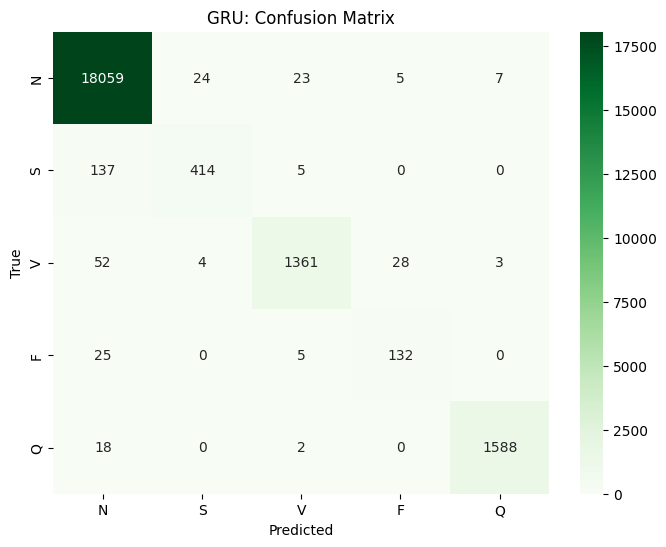

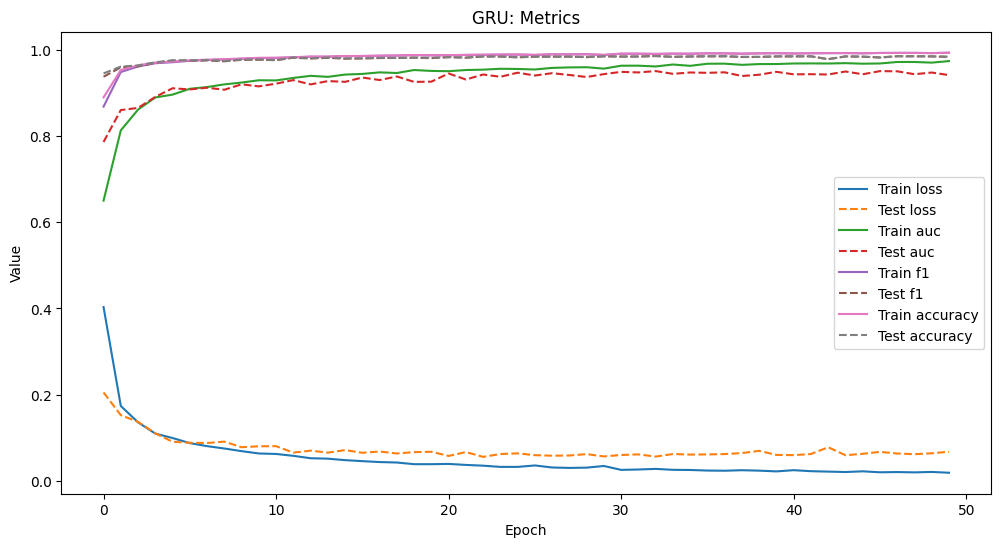

: 

In [ ]:
train_dataset = HeartbeatDataset(X_train, y_train)
test_dataset = HeartbeatDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

####START CODE HERE
input_size = 1
hidden_size = 128
num_layers = 2
num_classes = 5
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
exit(0)
#### END CODE HERE

models = {
    "RNN": RNNModel(input_size, hidden_size, num_layers, num_classes).to(device),
    "LSTM": LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device),
    "GRU": GRUModel(input_size, hidden_size, num_layers, num_classes).to(device)
}

criterion = nn.CrossEntropyLoss()
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_metrics = {"loss": [], "auc": [], "f1": [], "accuracy": []}
    test_metrics = {"loss": [], "auc": [], "f1": [], "accuracy": []}

    for epoch in range(num_epochs):
        train_loss, train_auc, train_f1, train_acc = train_model(model, criterion, optimizer, train_loader, device)
        train_metrics["loss"].append(train_loss)
        train_metrics["auc"].append(train_auc)
        train_metrics["f1"].append(train_f1)
        train_metrics["accuracy"].append(train_acc)

        test_loss, test_auc, test_f1, test_acc = evaluate_model(model, criterion, test_loader, device)
        test_metrics["loss"].append(test_loss)
        test_metrics["auc"].append(test_auc)
        test_metrics["f1"].append(test_f1)
        test_metrics["accuracy"].append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}, Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

    results[model_name] = (train_metrics, test_metrics)

    # Confusion Matrix
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    ####START CODE HERE
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    class_names = ['N', 'S', 'V', 'F', 'Q']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name}: Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_name}_confusion_matrix', dpi=300, bbox_inches='tight')
    plt.show()
    
    ### END CODE HERE

    plot_metrics(train_metrics, test_metrics, num_epochs, model_name)



### Discussion

RNN
- Final Metrics: 
    - Train Loss: 0.6624
    - Test Loss: 0.6638
    - Test AUC: 0.5000
    - Test F1: 0.7495
    - Test Acc: 0.8276
- Metrics Plot: There appears to be no significant change in any metric, with only a slight increase in train and test loss before becoming a flat line agian. 
- Confusion Matrix: Every sample was classified as N. 
- Notes: Despite the test accuracy being pretty high (82%), RNN is not effective at classifying heartbeats since every sample was classified as N. The accuracy is high due to the fact that majority of the true samples were N to begin with. Also, AUC (50%) implies that the model is randomly guessing.


LSTM
- Final Metrics: 
    - Train Loss: 0.0497
    - Test Loss: 0.0705
    - Test AUC: 0.9273
    - Test F1: 0.9808
    - Test Acc: 0.9815
- Metrics Plot: Looks good. 
- Confusion Matrix: Most samples were classified correctly. However, 144 S samples were classified as N. Only 390 S samples were classified correctly. All other classifications seem ok. 
- Notes: LSTM is effective and classifying heartbeats.

GRU
- Final Metrics: 
    - Train Loss: 0.0186
    - Test Loss: 0.0674
    - Test AUC: 0.9417
    - Test F1: 0.9841
    - Test Acc: 0.9846
- Metrics Plot: Looks good. 
- Confusion Matrix: Most samples were classified correctly. However, 137 S samples were classified as N. Only 414 S samples were classified correctly. All other classifications seem ok. The number of correct classifications per label are all higher compared to LSTM. 
- Notes: GRU is effective and classifying heartbeats.

Summary/Conclusion: Among the 3 models, RNN performed very poorly. Despite having a high Test Acc, RNN is not effective due to class imbalance, classifying every sample as N. This is further supported by the low AUC. LSTM and GRU performed very well, with high AUC, F1, and Acc. The biggest error apperas to be classifying some S as N; however, this is likely also due to class imbalance. Overall, GRU, with a simplier architecture, outperforms LSTM in every metric, as well as predictions per label. 

